In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
import sys
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
import os
from src import data
import json

In [99]:
############################################
path = "../../results/faithfulness_baselines_updated"
model_name = "gptj"
fig_dir = f"figs/{model_name}"
############################################
os.makedirs(fig_dir, exist_ok=True)
from scripts.faithfulness_baselines import load_raw_results

results_raw = load_raw_results(
    model_name, results_path=path, 
    multiple_files=False
    # multiple_files="llama" in model_name
)

In [100]:
def remove_none(arr):
    return [x for x in arr if x is not None]

def format_results(results_raw):
    results_formatted = {}
    for relation_results in results_raw:
        result = {k: v for k, v in relation_results.items() if k != "trials"}
        result["recall"] = {}
        if len(relation_results["trials"]) == 0:
            continue
        for trial_result in relation_results["trials"]:
            prompting_approaches = ["zero_shot", "icl"]
            for approach in prompting_approaches:
                if approach not in result["recall"]:
                    result["recall"][approach] = {}
                for method_key in trial_result[approach]:
                    if method_key not in result["recall"][approach]:
                        result["recall"][approach][method_key] = []
                    result["recall"][approach][method_key].append(trial_result[approach][method_key]["recall"])
        
        for approach in prompting_approaches:
            # print(f"{relation_results['relation_name']} -- {approach}")
            for method_key in result["recall"][approach]:
                # print(f" ====> {method_key} | {len(result['recall'][approach][method_key])}")
                try:
                    current_results = remove_none(result["recall"][approach][method_key])
                    result["recall"][approach][method_key] = np.array(current_results).mean(axis = 0)
                except:
                    print(result["recall"][approach][method_key])
                    raise Exception("ValueError")
        
        results_formatted[relation_results["relation_name"]] = result

    return results_formatted

results_formatted = format_results(results_raw)

In [101]:
dataset = data.load_dataset()
relations_by_name = {r.name: r for r in dataset.relations}

In [102]:
from typing import Literal

def segregate_categorywise(
    results_formatted: dict,
    property_key: Literal["relation_type", "fn_type", "disambiguating", "symmetric"] = "relation_type"
) -> dict:
    performance_category_wise = {}
    for relation_name in results_formatted:
        property_value = relations_by_name[relation_name].properties.__dict__[property_key]
        result = results_formatted[relation_name]
        if property_value not in performance_category_wise:
            performance_category_wise[property_value] = {}
        for prompting in result["recall"]:
            if prompting not in performance_category_wise[property_value]:
                performance_category_wise[property_value][prompting] = {}

            for method in result["recall"][prompting]:
                if method not in performance_category_wise[property_value][prompting]:
                    performance_category_wise[property_value][prompting][method] = []
                performance_category_wise[property_value][prompting][method].append(result["recall"][prompting][method])
        

    for property_value in performance_category_wise:
        for prompting in performance_category_wise[property_value]:
            for method in performance_category_wise[property_value][prompting]:
                performance_category_wise[property_value][prompting][method] = np.array(performance_category_wise[property_value][prompting][method]).mean(axis = 0)
    
    return performance_category_wise

In [103]:
performance_category_wise = segregate_categorywise(results_formatted, "relation_type")

In [104]:
category_order = ['factual', 'linguistic', 'bias', 'commonsense']
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 35+5
MEDIUM_SIZE = 50
BIGGER_SIZE = 55+5

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title

prompting_colors = {"zero_shot": "deepskyblue", "icl": "darkblue"}
method_name_dict  = {
    "logit_lens": "Logit Lens",
    "corner": "Corner Translation",
    "translation": "Translation",
    "learned_linear": "Linear Regression",
    "lre_emb": "R(e)",
    "lre": "R(s)",
    "corner_lre": "corner + LRE",
}
method_color  = {
    "logit_lens": "darkred",
    "corner": "black",
    "learned_linear": "olive",
    "lre_emb": "lightsteelblue",
    "lre": "darkblue",
    "translation": "purple"
}

method_order = [
    "lre", "lre_emb", 
    "learned_linear", 
    # "corner", 
    "translation", 
    "logit_lens"
][::-1]
#####################################################################################


def plot_categorywise(canvas, result, title, set_yticks = True, separate_prompting = True):
    bar_width = 0.4
    if separate_prompting:
        idx = 0
        for prompting in result:
            recalls = [result[prompting][method][0] for method in method_order]
            canvas.barh(
                np.arange(len(recalls)) + idx * bar_width, recalls, 
                height = bar_width, label = prompting.capitalize(), 
                color = prompting_colors[prompting],
                edgecolor = "black",
                alpha = 0.8
            )
            idx += 1
    else:
        prompting = "icl"
        recalls = [result[prompting][method][0] for method in method_order]
        canvas.barh(
            np.arange(len(recalls)), recalls, 
            height = bar_width*2, 
            color = "darkblue", #[method_color[method] for method in method_order],
            edgecolor = "black",
            alpha = 0.7
        )
    
    canvas.set_xlim(0, 1)
    canvas.set_title(title.capitalize(), fontsize = BIGGER_SIZE)

    if separate_prompting == False:
        canvas.set_yticks(np.arange(len(method_order)))
    else:    
        canvas.set_yticks(np.arange(len(method_order)) + 0.5 * bar_width)
    if set_yticks:
        canvas.set_yticklabels([method_name_dict[method] for method in method_order])
    else:
        canvas.set_yticklabels([""]*len(method_order))
    canvas.set_xticks(np.linspace(0, 1, 5))
        

/tmp/ipykernel_455682/1475999916.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


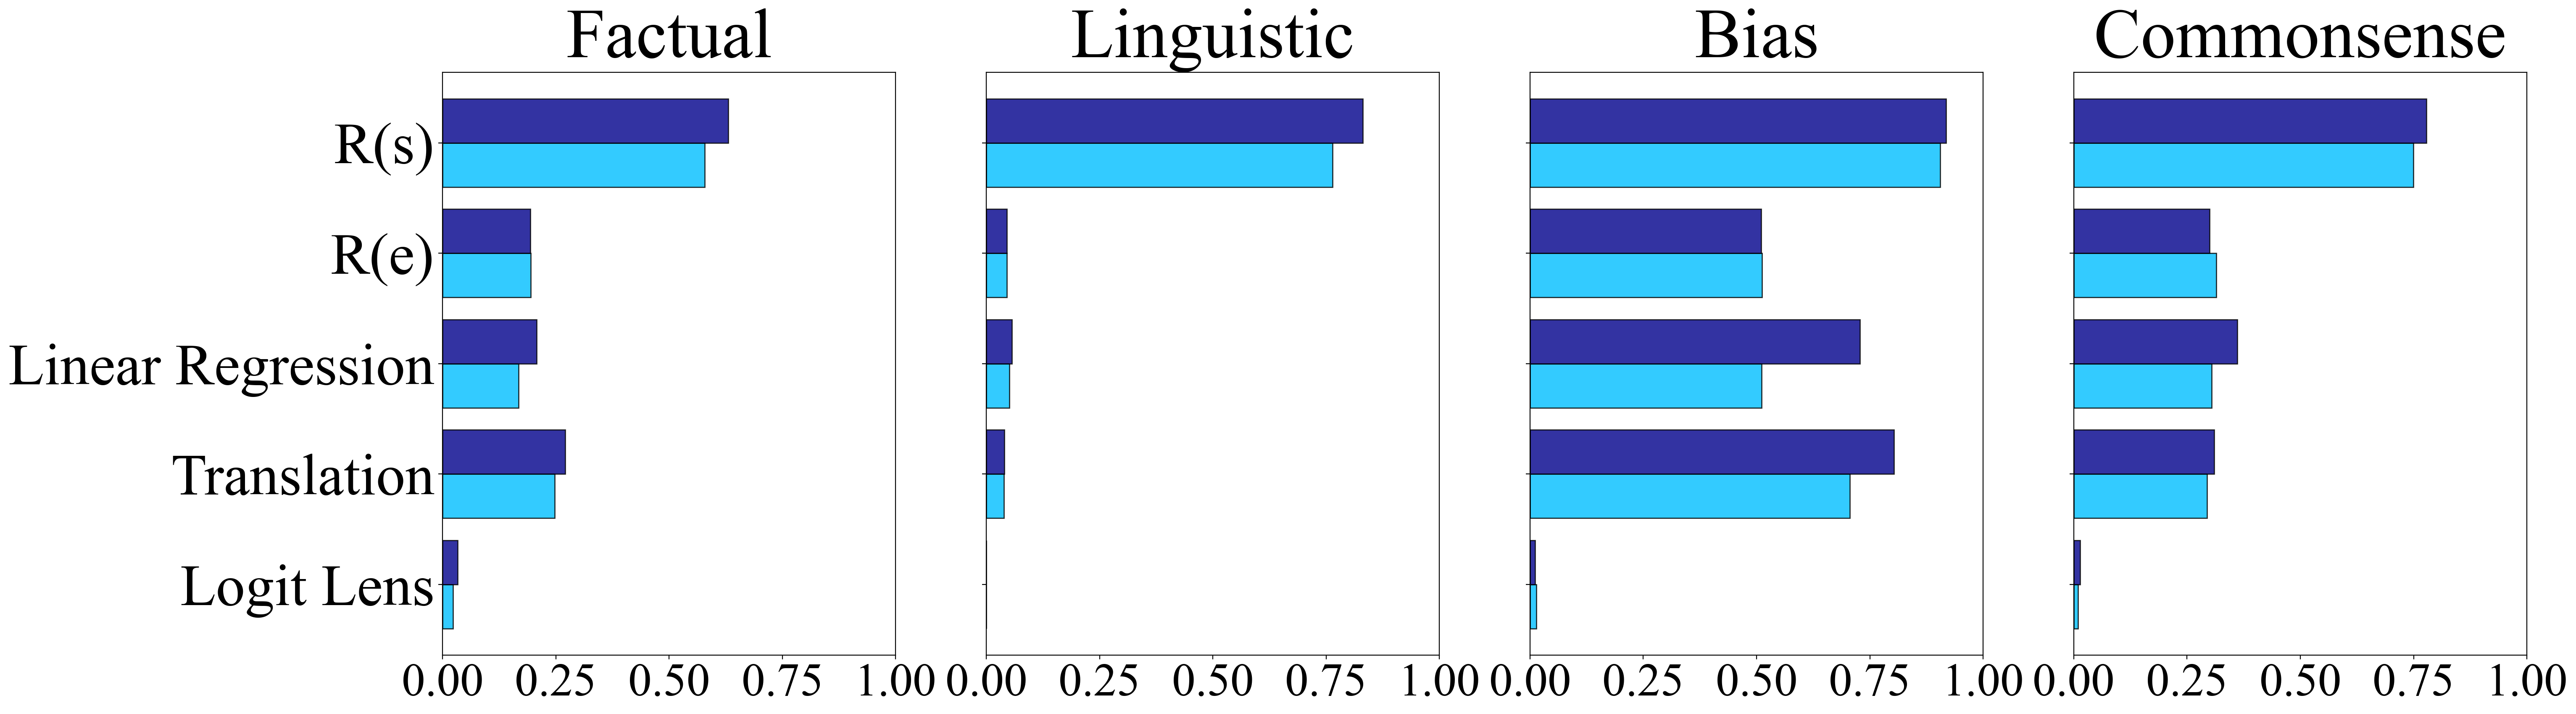

In [105]:
n_subplots = len(performance_category_wise)
ncols=4
nrows=int(np.ceil(n_subplots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 9))
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

ax_col, ax_row = 0, 0
# for i, (category, result) in enumerate(performance_category_wise.items()):
for category in category_order:
    result = performance_category_wise[category]
    plot_categorywise(canvas = axes[ax_row][ax_col], result = result, title = category, set_yticks = ax_col == 0)
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
    # break

plt.savefig(f"{fig_dir}/{model_name}-faithfulness_baselines_prompting.pdf", bbox_inches="tight")
fig.show()

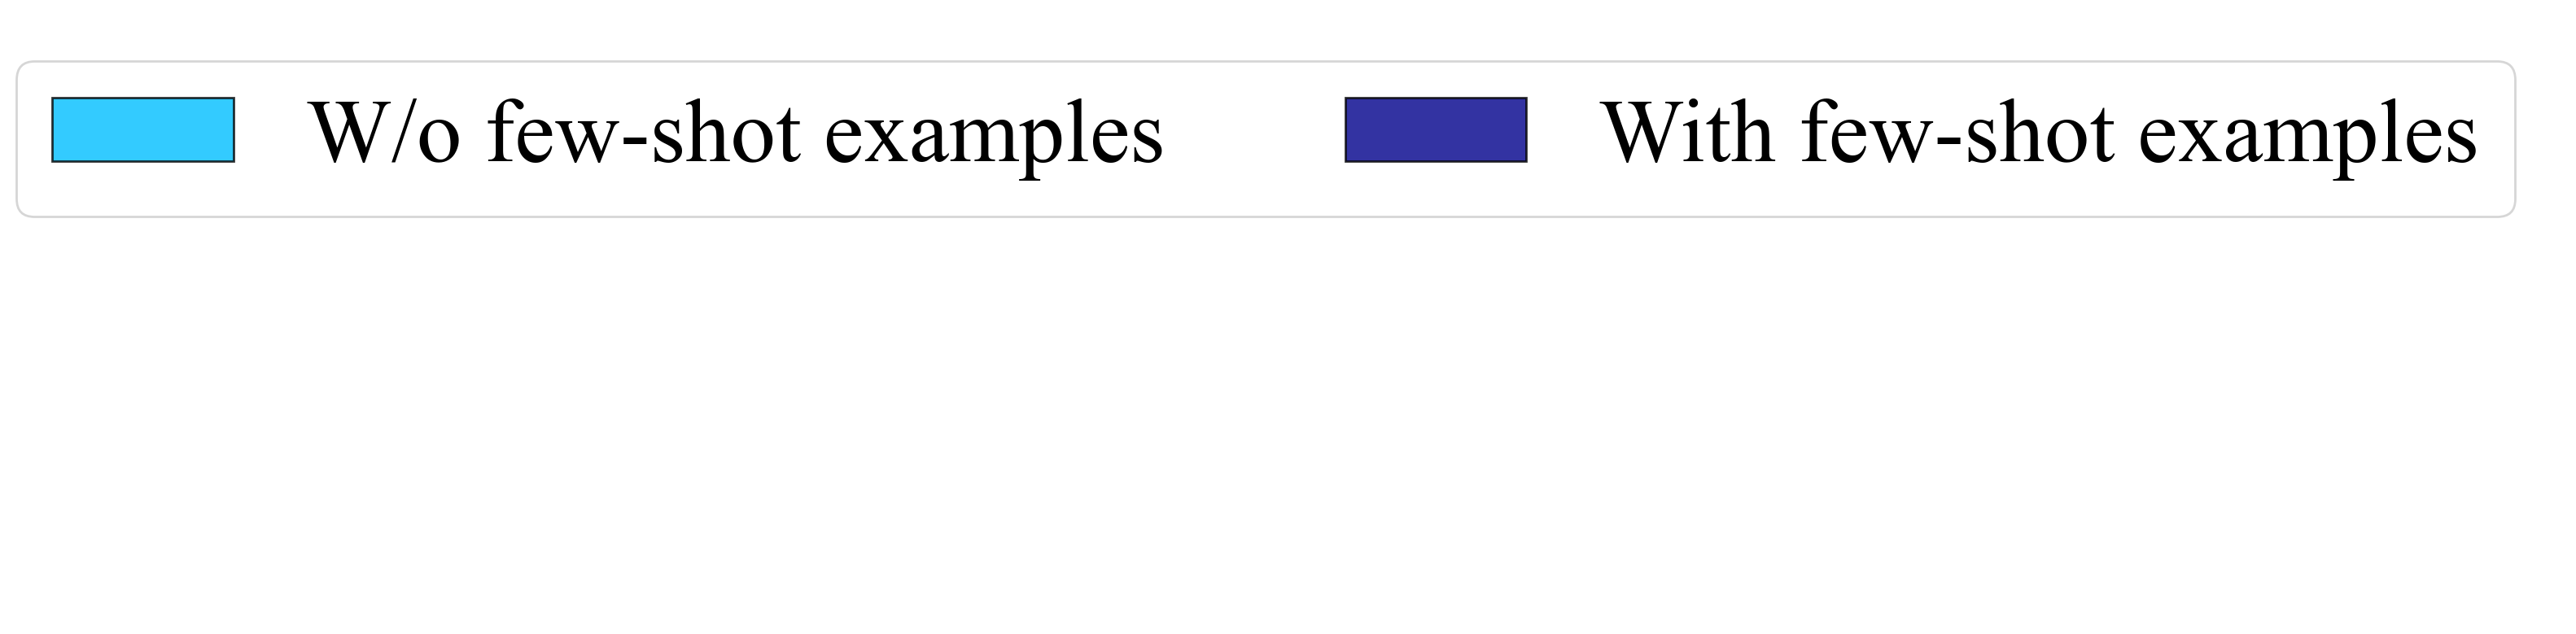

In [106]:
import matplotlib as mpl
palette = dict(zip(['W/o few-shot examples', "With few-shot examples"], ['deepskyblue', 'darkblue']))
handles = [mpl.patches.Patch(facecolor=palette[x], label=x, edgecolor="black", alpha=0.8) for x in palette.keys()]
# Create legend
plt.legend(handles=handles, ncols=2)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.savefig(f"{fig_dir}/legend_faithfulness_prompting.pdf", format="pdf", bbox_inches="tight")

/tmp/ipykernel_455682/3345001937.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


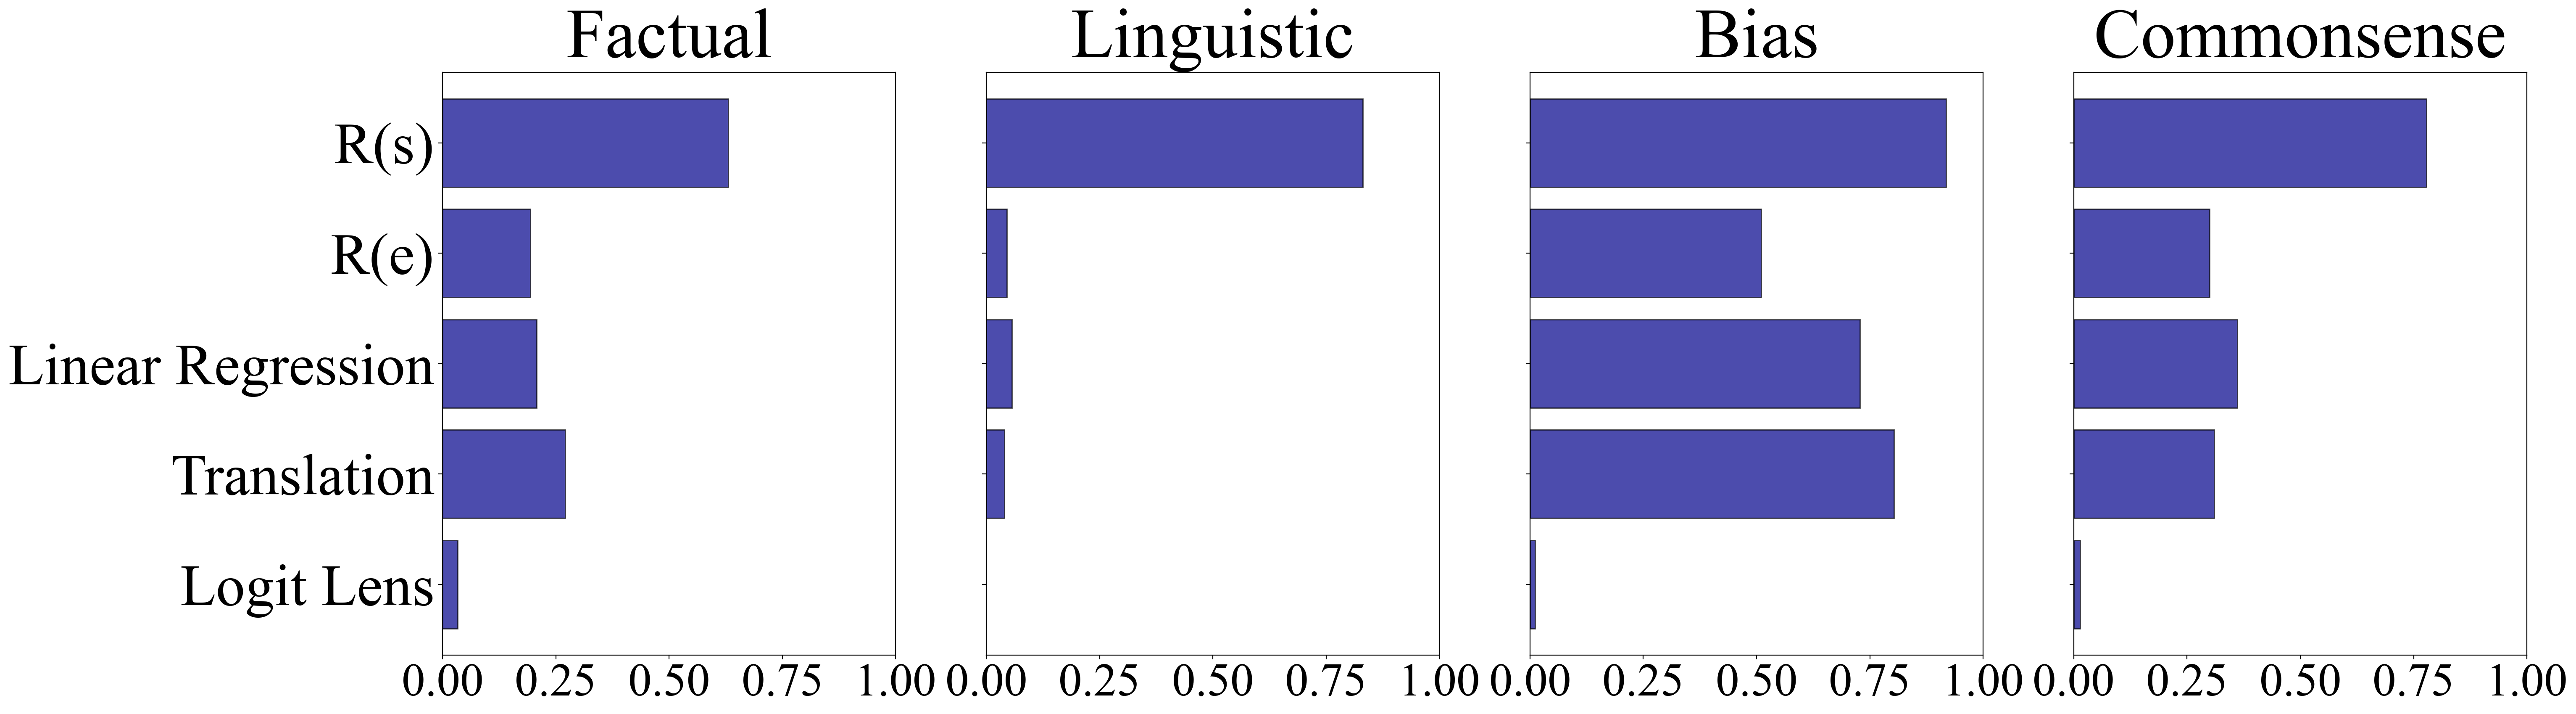

In [107]:
n_subplots = len(performance_category_wise)
ncols=4
nrows=int(np.ceil(n_subplots / ncols))

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 8, nrows * 9))
if nrows == 1:
    axes = [axes]
if ncols == 1:
    axes = [[ax] for ax in axes]

ax_col, ax_row = 0, 0
# for i, (category, result) in enumerate(performance_category_wise.items()):
for category in category_order:
    result = performance_category_wise[category]
    plot_categorywise(
        canvas = axes[ax_row][ax_col], result = result, 
        title = category, set_yticks = ax_col == 0,
        separate_prompting=False    
    )
    ax_col += 1
    if ax_col == ncols:
        ax_col = 0
        ax_row += 1
    # break

plt.savefig(f"{fig_dir}/{model_name}-faithfulness_baselines.pdf", bbox_inches="tight")
fig.show()

In [87]:
MODELS = [
    "gpt2-xl", 
    "gptj", 
    "llama-13b"
]
categorywise_results = {}

for model_name in MODELS:
    print(model_name)
    results_raw = load_raw_results(
        model_name, results_path=path, 
        multiple_files=False
    )
    results_formatted = format_results(results_raw)

    category_wise = segregate_categorywise(results_formatted, "relation_type")
    for category in category_wise:
        category_wise[category] = category_wise[category]['icl']["lre"][0]
    
    for category in category_wise:
        if category not in categorywise_results:
            categorywise_results[category] = {}
        categorywise_results[category][model_name] = category_wise[category]

categorywise_results

gpt2-xl
gptj
llama-13b


{'factual': {'gpt2-xl': 0.5450697448019208,
  'gptj': 0.6307725114710878,
  'llama-13b': 0.6033742612785895},
 'linguistic': {'gpt2-xl': 0.7381111048756215,
  'gptj': 0.830824250462414,
  'llama-13b': 0.8511007757397578},
 'bias': {'gpt2-xl': 0.8229283377024984,
  'gptj': 0.9179104247050454,
  'llama-13b': 0.8445460202142065},
 'commonsense': {'gpt2-xl': 0.6977287742646034,
  'gptj': 0.7787327154353206,
  'llama-13b': 0.6581804313054397}}

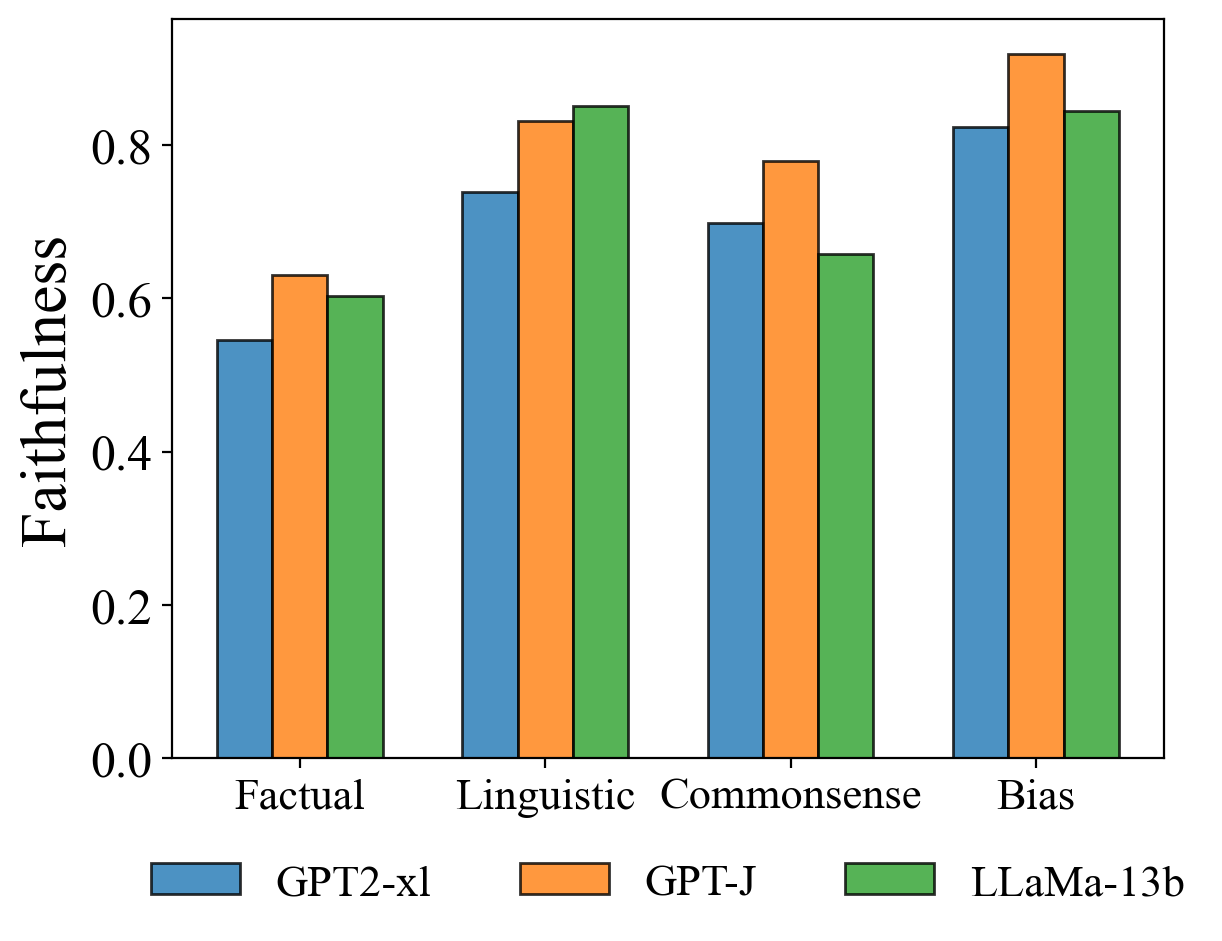

In [88]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=MEDIUM_SIZE+5)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=SMALL_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("axes", titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################


n_subplots = len(categorywise_results)
ncols=n_subplots
nrows=int(np.ceil(n_subplots / ncols))

category_order = ["factual", "linguistic", "commonsense", "bias"]
models = {
    "gpt2-xl": "GPT2-xl", 
    "gptj": "GPT-J", 
    "llama-13b": "LLaMa-13b"
}

idx = 0
bar_width = 0.225
for model in models:
    recalls = []
    for category in category_order:
        recalls.append(categorywise_results[category][model])
    
    plt.bar(
        np.arange(len(recalls)) + idx * bar_width, recalls,
        width = bar_width,
        label = models[model],
        edgecolor = "black",
        alpha = 0.8
    )
    idx += 1

plt.xticks(np.arange(len(recalls)) + bar_width, [cat.capitalize() for cat in category_order])
plt.ylabel("Faithfulness")
plt.legend(ncol = 3, bbox_to_anchor=(0.5, -.25), loc='lower center', frameon=False)
plt.savefig(f"figs/faithfulness_lre_models.pdf", bbox_inches="tight")
plt.show()

In [85]:
#####################################################################################
plt.rcParams["figure.dpi"] = 200
plt.rcParams["font.family"] = "Times New Roman"

SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 28

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=SMALL_SIZE)  # legend fontsize
plt.rc("figure", titlesize=BIGGER_SIZE)  # fontsize of the figure title
#####################################################################################

In [86]:
models = {
    "gpt2-xl": "GPT2-xl", 
    "gptj": "GPT-J", 
    "llama-13b": "LLaMa-13b"
}

model_name = "llama-13b"
results_raw = load_raw_results("llama-13b", results_path="results/faithfulne")
results_formatted = format_results(results_raw)

relation_and_recall = []

for relation_name in results_formatted:
    relation_and_recall.append({
        "relation": relation_name,
        "recall@1": results_formatted[relation_name]["recall"]['icl']["lre"][0]
    })

relation_and_recall = sorted(relation_and_recall, key = lambda x: x["recall@1"])

relations = [r["relation"] for r in relation_and_recall]
recalls = [r["recall@1"] for r in relation_and_recall]

plt.figure(figsize = (10, 20))
plt.barh(np.arange(len(relations)), recalls, color = "teal", alpha = 0.6)
plt.yticks(np.arange(len(relations)), relations)
plt.xticks(np.linspace(0, 1, 11), [np.round(v, 1) for v in np.linspace(0, 1, 11)])
plt.ylim(-0.7,len(relation_and_recall)-.3)
plt.xlabel("Recall@1")
plt.xlim(0, 1)

for x_tick in np.linspace(0, 1, 11):
    plt.axvline(x_tick, color = "black", alpha = 0.2)

plt.title(f"LRE faithfulness in ", x = 0.3, pad=15)
# plt.savefig(f"{fig_dir}/faithfulness_lre_relationwise.pdf", bbox_inches="tight")
plt.show()

TypeError: load_raw_results() missing 1 required positional argument: 'results_path'